In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

# We'll be using Pytorch's text library called torchtext! 
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

from tqdm.notebook import trange, tqdm

In [7]:
learning_rate = 1e-4

nepochs = 20

batch_size = 32

max_len = 128
data_set_root = "../../datasets"

# We'll be using the AG News Dataset
# Which contains a short news article and a single label to classify the "type" of article
# Note that for torchtext these datasets are NOT Pytorch dataset classes "AG_NEWS" is a function that
# returns a Pytorch DataPipe!

# Pytorch DataPipes vvv
# https://pytorch.org/data/main/torchdata.datapipes.iter.html

# vvv Good Blog on the difference between DataSet and DataPipe
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58
dataset_train = AG_NEWS(root=data_set_root, split="train")
dataset_test = AG_NEWS(root=data_set_root, split="test")

In [9]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# The vocab is all the unique tokens contained within our dataset
# and provides each token with it's own integer index.

# We will also add "special" tokens that we'll use to signal something to our model
# <pad> is a padding token that is added to the end of a sentance to ensure 
# the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
vocab = build_vocab_from_iterator(
    yield_tokens(dataset_train),
    min_freq=2, # Only include a token if it appears more than 2 times in the dataset
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'], # special case tokens
    special_first=True
)

# Set the <unk> "unknown" token as the default token
vocab.set_default_index(vocab['<unk>'])

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [11]:
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '.',
 'the',
 ',',
 'to',
 'a',
 'of',
 'in',
 'and',
 's',
 'on',
 'for',
 '#39',
 '(',
 ')',
 '-',
 "'",
 'that',
 'with',
 'as',
 'at',
 'is',
 'its',
 'new',
 'by',
 'it',
 'said',
 'reuters',
 'has',
 'from',
 'an',
 'ap',
 'his',
 'will',
 'after',
 'was',
 'us',
 'be',
 'over',
 'have',
 'their',
 '&lt',
 'are',
 'up',
 'quot',
 'but',
 'more',
 'first',
 'two',
 'he',
 'world',
 'u',
 'this',
 '--',
 'company',
 'monday',
 'wednesday',
 'tuesday',
 'oil',
 'out',
 'thursday',
 'one',
 'not',
 'against',
 'inc',
 'friday',
 'into',
 'they',
 'about',
 'last',
 'iraq',
 'year',
 'than',
 'york',
 'yesterday',
 'who',
 'president',
 'microsoft',
 'no',
 'were',
 '?',
 'been',
 'million',
 't',
 'says',
 'week',
 'had',
 'corp',
 'united',
 'game',
 'when',
 'sunday',
 'prices',
 'could',
 'three',
 'would',
 'today',
 'years',
 'group',
 'security',
 'government',
 'time',
 'people',
 'which',
 'may',
 'afp',
 'percent',
 'software',
 '1',


In [25]:
text_transform = T.Sequential(
    T.VocabTransform(vocab = vocab),
    T.AddToken(1, begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2, begin=False),
    T.ToTensor(padding_value=0)

)

In [13]:
text_tokenizer = lambda batch: [tokenizer(x) for x in batch]
data_loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle =True, num_workers=4, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle =True, num_workers=4)

In [15]:
class LSTM(nn.Module):
    def __init__(self,  embedding_size, output_size, num_layers=1, hidden_size = 128):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(embedding_size, hidden_size)
        self.lstm = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        input_embeds = self.embedding(input_seq)
        output, (hidden_out, mem_out) = self.lstm(input_embeds, (hidden_in, mem_in))
        return self.fc_out(output), hidden_out, mem_out




In [17]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cpu')

In [20]:
hidden_size = 64
num_layers = 3

lstm_classifier = LSTM(embedding_size = len(vocab), output_size= 4, 
                       num_layers= num_layers, hidden_size= hidden_size).to(device)

optimizer = optim.Adam(lstm_classifier.parameters(), lr =learning_rate)

loss_fn = nn.CrossEntropyLoss()

In [22]:
num_model_params = 0
for param in lstm_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))


-This Model Has 3500420 (Approximately 3 Million) Parameters!


In [23]:
training_loss_logger = []
test_loss_logger = []

training_acc_logger = []
test_acc_logger = []

In [26]:
pbar = trange(0, nepochs, leave=False, desc="Epoch")    
train_acc = 0
test_acc = 0
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%' % (train_acc * 100, test_acc * 100))
    
    lstm_classifier.train()
    steps = 0
    for label, text in tqdm(data_loader_train, desc="Training", leave=False):
        bs = label.shape[0]
        text_tokens = text_transform(text_tokenizer(text)).to(device)
        label = (label - 1).to(device)
        
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

        loss = loss_fn(pred[:, -1, :], label)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_logger.append(loss.item())
        
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        
    train_acc = (train_acc/steps).item()
    training_acc_logger.append(train_acc)
    
    lstm_classifier.eval()
    steps = 0
    with torch.no_grad():
        for label, text in tqdm(data_loader_test, desc="Testing", leave=False):
            bs = label.shape[0]
            text_tokens = text_transform(text_tokenizer(text)).to(device)
            label = (label - 1).to(device)

            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
/Users/harshayarravarapu/Library/Python/3.9/lib/python/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child D

Testing: 0it [00:00, ?it/s]

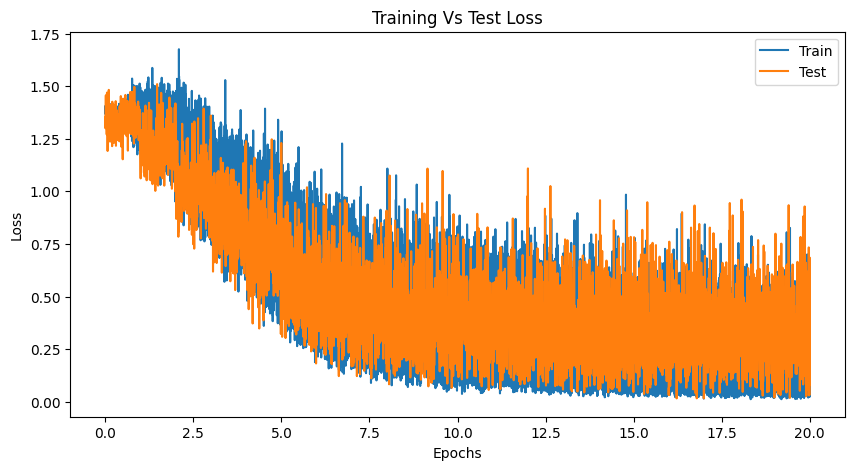

In [27]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

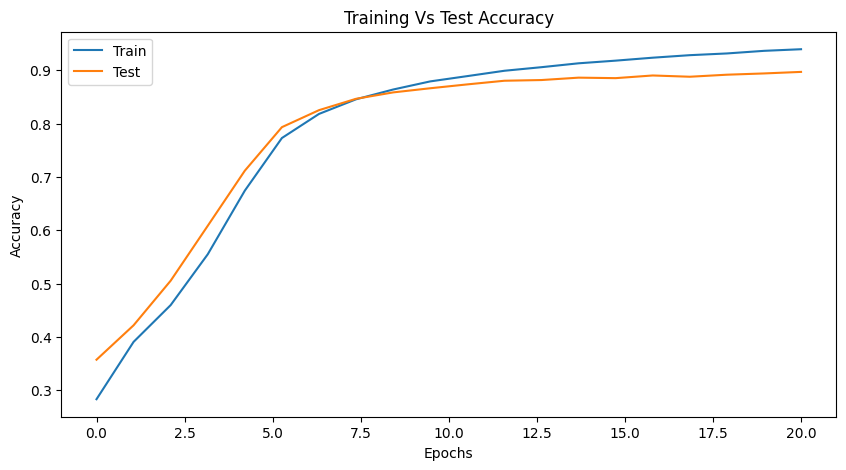

In [28]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")

In [29]:
#results